In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

In [2]:
import pandas as pd
import numpy as np
import paddle
import paddle_quantum
from paddle_quantum.dataset import *
from paddle_quantum.ansatz import Circuit
from numpy import pi as PI
from paddle import matmul, transpose, reshape 
from paddle_quantum.qinfo import pauli_str_to_matrix  
from paddle_quantum.linalg import dagger 
from matplotlib import pyplot as plt
#Noted that paddle quantum use some function from old version numpy so warning messages are expected

C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\urllib3\util\selectors.py:14: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import namedtuple, Mapping
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\urllib3\_collections.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\openfermion\hamiltonians\hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\tensor\creatio

In [4]:
#Pauli operators for observation, see section 1.2 step 3
def Observable(n):
    Ob = pauli_str_to_matrix([[1.0, 'z0']], n)

    return Ob

In [9]:
#This part defines 
class model(paddle_quantum.Operator):
   
    def __init__(self, n, depth, seed_paras=123):
        super(model, self).__init__()
        self.n = n
        self.depth = depth
        paddle.seed(seed_paras)
        self.bias = self.create_parameter(
            shape=[1],
            default_initializer=paddle.nn.initializer.Normal(std=0.01),
            dtype='float32',
            is_bias=False)
        
        #Add rotation gates to the circuit
        #Circuit structure in section 1.4
        self.circuit = Circuit(n)
        self.circuit.rx()
        self.circuit.ry()
        self.circuit.rz()
        for _ in range(depth):
            self.circuit.cnot()
            self.circuit.ry()
      
            
    def forward(self, state_in, label):
        
        Ob = paddle.to_tensor(Observable(self.n))
        label_pp = reshape(paddle.to_tensor(label), [-1, 1])

       
        Utheta = self.circuit.unitary_matrix()

        
        state_out = matmul(state_in, Utheta) 

       
        E_Z = matmul(matmul(state_out, Ob), transpose(paddle.conj(state_out), perm=[0, 2, 1]))
        #Mapping function in section 1.5
        sd = paddle.nn.Sigmoid()
        state_predict =  sd(paddle.real(E_Z)[:, 0]) +self.bias
       
        #Loss function discussed in 1.6
        loss = paddle.mean((state_predict - label_pp) ** 2)  

        is_correct = (paddle.abs(state_predict - label_pp) < 0.5).nonzero().shape[0]
        acc = is_correct / label.shape[0]

        return loss, acc, state_predict.numpy(), self.circuit

In [6]:
#train function for the qnn
def train(quantum_train_x, train_y,quantum_test_x,test_y, N, DEPTH, EPOCH, LR, BATCH):
    Ntrain = len(quantum_train_x)

    net = model(n=N, depth=DEPTH)

    
    summary_loss,summary_iter, summary_test_acc = [], [],[]
    summary_train_acc = []
    
    opt = paddle.optimizer.Adam(learning_rate=LR, parameters=net.parameters())

    
    for ep in range(EPOCH):
        for itr in range(Ntrain // BATCH):
            
            input_state = quantum_train_x[itr * BATCH:(itr + 1) * BATCH]  
            input_state = reshape(input_state, [-1, 1, 2 ** N])
            label = train_y[itr * BATCH:(itr + 1) * BATCH]
            
            
            test_input_state = reshape(quantum_test_x, [-1, 1, 2 ** N])

            loss, train_acc, state_predict_useless, cir = net(state_in=input_state, label=label)

            
                
            loss_useless, test_acc, state_predict_useless, t_cir = net(state_in=test_input_state, label=test_y)
            if itr % 5 == 0:
                print("Epoch:", ep, "Iter:", itr,
                      "Loss: %.4f" % loss.numpy(),
                      "Train acc: %.4f" % train_acc,
                      "Test acc: %.4f" % test_acc)
            summary_train_acc.append(train_acc)
            summary_test_acc.append(test_acc)
            summary_loss.append(loss.numpy())

            loss.backward()
            opt.minimize(loss)
            opt.clear_grad()
        test_input_state = reshape(quantum_test_x, [-1, 1, 2 ** N])
        loss_useless, test_acc, state_predict_useless, t_cir = net(state_in=test_input_state, label=test_y)
        print("Final test acc: %.4f" % test_acc)
    print(cir)
    return summary_test_acc,summary_loss,summary_train_acc

In [7]:
#This part reads the train and test data set
train_data = pd.read_csv('train.csv')
train_y = train_data['Survival']
train_x = train_data.drop(['Survival'],axis = 1)
test_data = pd.read_csv('test.csv')
test_y = test_data['Survival']
test_x = test_data.drop(['Survival'],axis = 1)
train_x = train_x.to_numpy()
train_y = train_y.to_numpy()
test_x = test_x.to_numpy()
test_y = test_y.to_numpy()
train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)
train_x.shape,train_y.shape

((200, 3), (200, 1))

# This part is change of Learning rate Result


Noted that *depth of circuit, number of epoch, batch number* are fixed

Learning rate are 0.5,0.25,0.125 and 0.0625

Learning rate: 0.5
Depth of ciruit: 1
Number of epochs: 1
Batch number: 10
Epoch: 0 Iter: 0 Loss: 0.2596 Train acc: 0.5000 Test acc: 0.7453
Epoch: 0 Iter: 5 Loss: 0.1827 Train acc: 0.8000 Test acc: 0.7453


C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
C:\Users\ThinkPad\AppData\Roaming\Python\Python39\site-packages\paddle\fluid\dygraph\math_op_patch.py:276: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.int64, the right dtype will convert to paddle.float32
  warnings.warn(


Epoch: 0 Iter: 10 Loss: 0.2328 Train acc: 0.7000 Test acc: 0.7453
Epoch: 0 Iter: 15 Loss: 0.1360 Train acc: 0.8000 Test acc: 0.7453
Final test acc: 0.7453
--Rx(6.061)----Ry(7.240)----Rz(5.583)----*----x----Ry(6.427)--
                                         |    |               
--Rx(7.469)----Ry(5.694)----Rz(6.506)----x----*----Ry(-4.64)--
                                                              


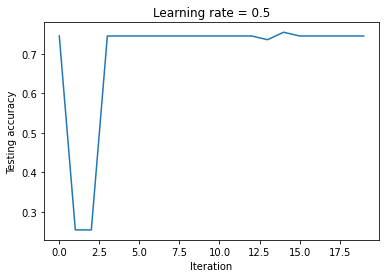

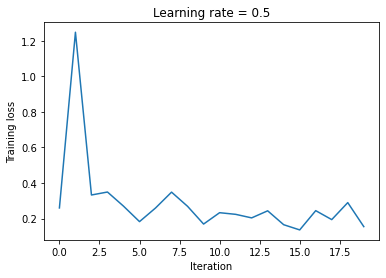

Learning rate: 0.25
Depth of ciruit: 1
Number of epochs: 1
Batch number: 10
Epoch: 0 Iter: 0 Loss: 0.2596 Train acc: 0.5000 Test acc: 0.7453
Epoch: 0 Iter: 5 Loss: 0.1799 Train acc: 0.8000 Test acc: 0.7453
Epoch: 0 Iter: 10 Loss: 0.2257 Train acc: 0.7000 Test acc: 0.7453
Epoch: 0 Iter: 15 Loss: 0.1356 Train acc: 0.8000 Test acc: 0.7453
Final test acc: 0.7453
--Rx(4.813)----Ry(6.004)----Rz(4.434)----*----x----Ry(7.961)--
                                         |    |               
--Rx(6.104)----Ry(5.101)----Rz(6.063)----x----*----Ry(1.423)--
                                                              


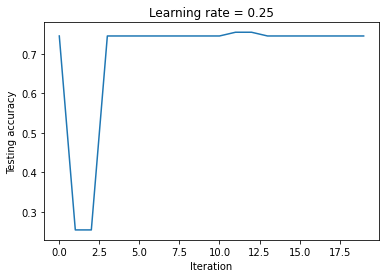

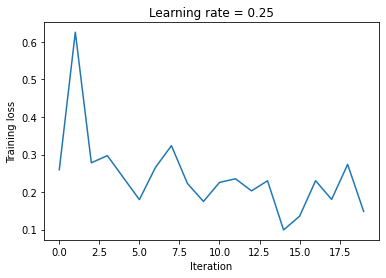

Learning rate: 0.125
Depth of ciruit: 1
Number of epochs: 1
Batch number: 10
Epoch: 0 Iter: 0 Loss: 0.2596 Train acc: 0.5000 Test acc: 0.7453
Epoch: 0 Iter: 5 Loss: 0.1706 Train acc: 0.8000 Test acc: 0.7453
Epoch: 0 Iter: 10 Loss: 0.2227 Train acc: 0.7000 Test acc: 0.7453
Epoch: 0 Iter: 15 Loss: 0.1591 Train acc: 0.8000 Test acc: 0.7453
Final test acc: 0.7453
--Rx(4.404)----Ry(5.687)----Rz(4.261)----*----x----Ry(4.717)--
                                         |    |               
--Rx(6.080)----Ry(4.910)----Rz(5.999)----x----*----Ry(0.622)--
                                                              


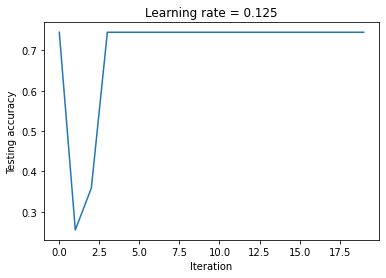

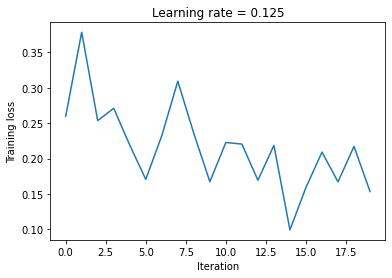

Learning rate: 0.0625
Depth of ciruit: 1
Number of epochs: 1
Batch number: 10
Epoch: 0 Iter: 0 Loss: 0.2596 Train acc: 0.5000 Test acc: 0.7453
Epoch: 0 Iter: 5 Loss: 0.1824 Train acc: 0.8000 Test acc: 0.7453
Epoch: 0 Iter: 10 Loss: 0.2177 Train acc: 0.7000 Test acc: 0.7453
Epoch: 0 Iter: 15 Loss: 0.1643 Train acc: 0.8000 Test acc: 0.7453
Final test acc: 0.7453
--Rx(4.196)----Ry(5.657)----Rz(4.173)----*----x----Ry(3.876)--
                                         |    |               
--Rx(6.219)----Ry(4.886)----Rz(6.060)----x----*----Ry(0.431)--
                                                              


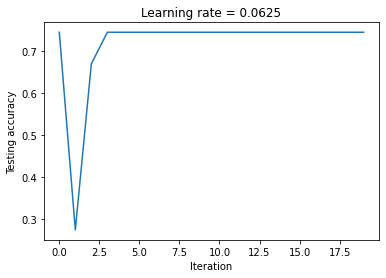

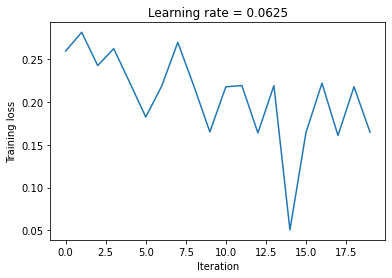

In [10]:
num_qubit = 2
dimension = 3
#Encode information, discussed in section 1.3
encoding = 'amplitude_encoding'
quantum_train_x= SimpleDataset(dimension).encode(train_x, encoding, num_qubit)
quantum_test_x= SimpleDataset(dimension).encode(test_x, encoding, num_qubit)
quantum_train_x = paddle.to_tensor(quantum_train_x)
quantum_test_x = paddle.to_tensor(quantum_test_x)
for i in range(4):
    
    
    lr = 0.5/(2**i)
    dep = 1
    ep = 1
    bt = 10
    
    print(f'Learning rate: {lr}')
    print(f'Depth of ciruit: {dep}')
    print(f'Number of epochs: {ep}')
    print(f'Batch number: {bt}')
    #Hyperparameters are
    # Depth of cirucit DEPTH 
    # Number of epochs EPOCH
    # Learning rate LR
    # Batch number BATCH
    test_acc,loss,train_acc= train(
            quantum_train_x, 
            train_y,         
            quantum_test_x,  
            test_y,          
            N = num_qubit,   
            DEPTH = dep,       
            EPOCH = ep,       
            LR = lr,        
            BATCH = bt     
          )
    #plot of result
    plt.plot(test_acc)
    plt.title(f'Learning rate = {lr}')
    plt.xlabel("Iteration")
    plt.ylabel("Testing accuracy")
    plt.show()
    
    plt.plot(loss)
    plt.title(f'Learning rate = {lr}')
    plt.xlabel("Iteration")
    plt.ylabel("Training loss")
    plt.show()

# This part is result of change of depth

Noted that *learning rate, number of epoch, batch number* are fixed

Depth of circuit are 1,2,3

Learning rate: 0.1
Depth of ciruit: 1
Number of epochs: 1
Batch number: 10
Epoch: 0 Iter: 0 Loss: 0.2757 Train acc: 0.3000 Test acc: 0.5849
Epoch: 0 Iter: 5 Loss: 0.1710 Train acc: 0.8000 Test acc: 0.7453
Epoch: 0 Iter: 10 Loss: 0.2214 Train acc: 0.7000 Test acc: 0.7453
Epoch: 0 Iter: 15 Loss: 0.1802 Train acc: 0.8000 Test acc: 0.7453
Final test acc: 0.7453
--Rx(5.092)----Ry(5.425)----Rz(4.109)----*----x----Ry(3.606)--
                                         |    |               
--Rx(6.190)----Ry(4.982)----Rz(5.952)----x----*----Ry(0.594)--
                                                              


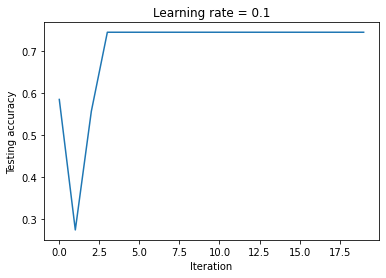

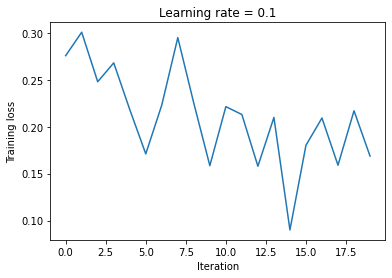

Learning rate: 0.1
Depth of ciruit: 4
Number of epochs: 1
Batch number: 10
Epoch: 0 Iter: 0 Loss: 0.2644 Train acc: 0.5000 Test acc: 0.2736
Epoch: 0 Iter: 5 Loss: 0.1677 Train acc: 0.8000 Test acc: 0.7453
Epoch: 0 Iter: 10 Loss: 0.2142 Train acc: 0.7000 Test acc: 0.7453
Epoch: 0 Iter: 15 Loss: 0.1610 Train acc: 0.8000 Test acc: 0.7453
Final test acc: 0.7453
--Rx(4.215)----Ry(4.526)----Rz(4.143)----*----x----Ry(4.033)----*----x----Ry(5.851)----*----x----Ry(2.755)----*----x----Ry(5.608)--
                                         |    |                 |    |                 |    |                 |    |               
--Rx(6.229)----Ry(5.169)----Rz(5.973)----x----*----Ry(0.943)----x----*----Ry(3.129)----x----*----Ry(0.066)----x----*----Ry(1.697)--
                                                                                                                                   


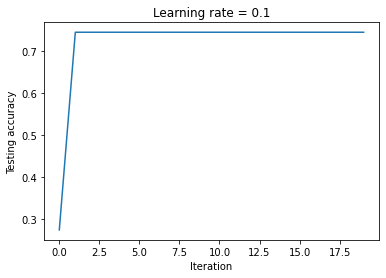

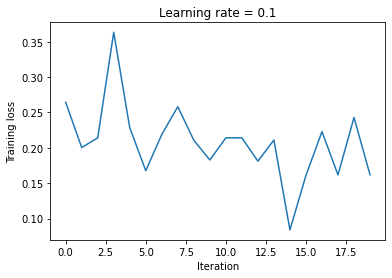

Learning rate: 0.1
Depth of ciruit: 8
Number of epochs: 1
Batch number: 10
Epoch: 0 Iter: 0 Loss: 0.2591 Train acc: 0.5000 Test acc: 0.2453
Epoch: 0 Iter: 5 Loss: 0.1646 Train acc: 0.8000 Test acc: 0.7453
Epoch: 0 Iter: 10 Loss: 0.2171 Train acc: 0.7000 Test acc: 0.7453
Epoch: 0 Iter: 15 Loss: 0.1625 Train acc: 0.8000 Test acc: 0.7453
Final test acc: 0.7453
--Rx(4.054)----Ry(5.221)----Rz(4.079)----*----x----Ry(3.641)----*----x----Ry(5.339)----*----x----Ry(2.611)----*----x----Ry(5.347)----*----x----Ry(4.415)----*----x----Ry(5.451)----*----x----Ry(1.819)----*----x----Ry(0.701)--
                                         |    |                 |    |                 |    |                 |    |                 |    |                 |    |                 |    |                 |    |               
--Rx(6.033)----Ry(5.064)----Rz(5.896)----x----*----Ry(0.246)----x----*----Ry(2.737)----x----*----Ry(0.469)----x----*----Ry(2.539)----x----*----Ry(1.953)----x----*----Ry(5.631)----x----*----Ry(

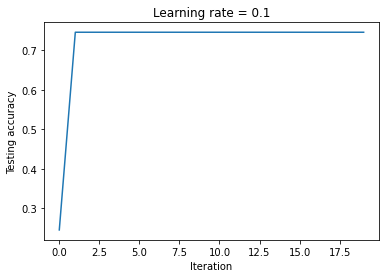

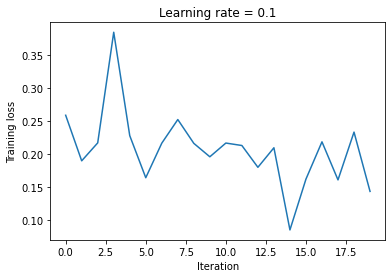

Learning rate: 0.1
Depth of ciruit: 100
Number of epochs: 1
Batch number: 10
Epoch: 0 Iter: 0 Loss: 0.2564 Train acc: 0.5000 Test acc: 0.7453
Epoch: 0 Iter: 5 Loss: 0.2129 Train acc: 0.8000 Test acc: 0.7453
Epoch: 0 Iter: 10 Loss: 0.2901 Train acc: 0.7000 Test acc: 0.7453
Epoch: 0 Iter: 15 Loss: 0.1628 Train acc: 0.8000 Test acc: 0.7453
Final test acc: 0.7453
--Rx(3.644)----Ry(4.808)----Rz(3.637)----*----x----Ry(3.332)----*----x----Ry(4.930)----*----x----Ry(2.133)----*----x----Ry(6.344)----*----x----Ry(5.046)----*----x----Ry(4.547)----*----x----Ry(1.190)----*----x----Ry(0.075)----*----x----Ry(4.798)----*----x----Ry(5.849)----*----x----Ry(1.885)----*----x----Ry(3.437)----*----x----Ry(2.395)----*----x----Ry(3.697)----*----x----Ry(6.474)----*----x----Ry(0.244)----*----x----Ry(1.987)----*----x----Ry(4.367)----*----x----Ry(3.298)----*----x----Ry(4.474)----*----x----Ry(6.182)----*----x----Ry(5.956)----*----x----Ry(5.342)----*----x----Ry(0.633)----*----x----Ry(5.799)----*----x----Ry(4.606)---

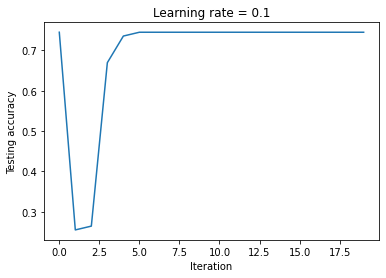

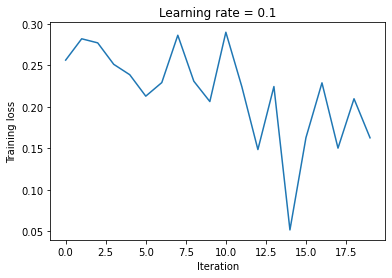

In [11]:
num_qubit = 2
dimension = 3
encoding = 'angle_encoding'
quantum_train_x= SimpleDataset(dimension).encode(train_x, encoding, num_qubit)
quantum_test_x= SimpleDataset(dimension).encode(test_x, encoding, num_qubit)
quantum_train_x = paddle.to_tensor(quantum_train_x)
quantum_test_x = paddle.to_tensor(quantum_test_x)
d = [1,4,8,100]
for i in range(4):
    lr = 0.1
    dep = d[i]
    ep = 1
    bt = 10
    print(f'Learning rate: {lr}')
    print(f'Depth of ciruit: {dep}')
    print(f'Number of epochs: {ep}')
    print(f'Batch number: {bt}')
    #Hyperparameters are
    # Depth of cirucit DEPTH 
    # Number of epochs EPOCH
    # Learning rate LR
    # Batch number BATCH
    test_acc,loss,train_acc= train(
            quantum_train_x, 
            train_y,         
            quantum_test_x,  
            test_y,          
            N = num_qubit,   
            DEPTH = dep,       
            EPOCH = ep,       
            LR = lr,        
            BATCH = bt     
          )
    #plot of result
    plt.plot(test_acc)
    plt.title(f'Learning rate = {lr}')
    plt.xlabel("Iteration")
    plt.ylabel("Testing accuracy")
    plt.show()
    
    plt.plot(loss)
    plt.title(f'Learning rate = {lr}')
    plt.xlabel("Iteration")
    plt.ylabel("Training loss")
    plt.show()

# This part is result of traditional method

Check the last summary table of results

In [12]:
#Use a powerful package autogluon to run other models 
#The program will store the parameters of all models in the folder 'agModels-predictClass' in the same path of this program 
from autogluon.tabular import TabularDataset, TabularPredictor
train_data = TabularDataset('train.csv')
label = 'Survival'
save_path = 'agModels-predictClass'
predictor = TabularPredictor(label=label, path=save_path).fit(train_data)
test_data = TabularDataset('test.csv')
predictor = TabularPredictor.load("agModels-predictClass")
predictor.evaluate(test_data, silent=True)
predictor.leaderboard(test_data, silent=True)

Loaded data from: train.csv | Columns = 4 / 4 | Rows = 200 -> 200
Beginning AutoGluon training ...
AutoGluon will save models to "agModels-predictClass\"
AutoGluon Version:  0.7.0
Python Version:     3.9.13
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Train Data Rows:    200
Train Data Columns: 3
Label Column: Survival
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9145.37 MB
	Train Data (Original)  Memory Usage: 0.0 MB (0.0% of available memory)
	Infe

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost,0.764151,0.750,0.010969,0.004989,0.173534,0.010969,0.004989,0.173534,1,True,11
1,LightGBMXT,0.754717,0.775,0.002992,0.001994,0.208444,0.002992,0.001994,0.208444,1,True,3
2,WeightedEnsemble_L2,0.754717,0.775,0.005983,0.001994,0.588429,0.002991,0.000000,0.379986,2,True,14
3,LightGBMLarge,0.745283,0.750,0.002992,0.001997,0.261302,0.002992,0.001997,0.261302,1,True,13
4,KNeighborsUnif,0.745283,0.675,0.012966,0.014935,3.834569,0.012966,0.014935,3.834569,1,True,1
5,RandomForestGini,0.745283,0.625,0.084773,0.031915,0.441819,0.084773,0.031915,0.441819,1,True,5
6,LightGBM,0.735849,0.775,0.000997,0.000997,0.181514,0.000997,0.000997,0.181514,1,True,4
7,KNeighborsDist,0.735849,0.700,0.009974,0.010971,0.003989,0.009974,0.010971,0.003989,1,True,2
8,NeuralNetFastAI,0.735849,0.725,0.019948,0.017922,2.005631,0.019948,0.017922,2.005631,1,True,10
9,RandomForestEntr,0.735849,0.625,0.060838,0.031914,0.296939,0.060838,0.031914,0.296939,1,True,6
